In [1]:
#meta 4/4/2022 TensorFlow2 Introducing the Keras Functional API (not on Vertex AI Platform)
# src course Introduction to TensorFlow
# git clone https://github.com/GoogleCloudPlatform/training-data-analyst 
# file src: https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/labs/3_keras_functional_api.ipynb

#infra: work laptop, env anya_tf2
#$issue with plotting model - figure out graphviz on Windows, for now - draw a static image
#  tried
#  pip install pydotplus, pip install graphviz
#  pydot 1.4.2 (already installed), pydotplus 2.0.2, graphviz 0.19.1
#  added to env vars: C:\Anaconda3\Lib\site-packages and C:\Anaconda3\Lib\site-packages\graphviz
#  also tried 
#  conda install graphviz but 
#  get security error CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://repo.anaconda.com/pkgs/main/win-64/current_repodata.json>
#  ...current network has https://www.anaconda.com blocked

#In the notebook interface, navigate to 
#  training-data-analyst > courses > machine_learning > deepdive2 > introduction_to_tensorflow > labs, 
#  and open 4_keras_functional_api.ipynb
#Look at the complete solution, navigate to 
#  training-data-analyst > courses > machine_learning > deepdive2 > introduction_to_tensorflow > solutions, 
#  and open 4_keras_functional_api.ipynb

#history
#4/4/2022 REVIEW
#      
#      Understand embeddings and how to create them with the feature column API.
#      Understand Deep and Wide models and when to use them.
#      Understand the Keras functional API and how to build a deep and wide model with it.
#      High-level model evaluation
#      Make predictions with the Keras model
#
#      here: Build a Wide & Deep model using the Keras Functional API; call our model for online prediciton.
#      $note: Deploy and predict in GCP and Vertex AI wouldn't work outside of GCP, refer to solution file.

# Introducing the Keras Functional API on Vertex AI Platform

**Learning objectives**
  1. Understand embeddings and how to create them with the feature column API.
  1. Understand Deep and Wide models and when to use them.
  1. Understand the Keras functional API and how to build a deep and wide model with it.
  1. Learn how to deploy the Model to Vertex AI and make predictions with the Keras model.

## Introduction

In the last notebook, you learned about the Keras Sequential API. The [Keras Functional API](https://www.tensorflow.org/guide/keras#functional_api) provides an alternate way of building models which is more flexible. With the Functional API, we can build models with more complex topologies, multiple input or output layers, shared layers or non-sequential data flows (e.g. residual layers).

In this notebook you'll use what we learned about feature columns to build a Wide & Deep model. Recall, that the idea behind Wide & Deep models is to join the two methods of learning through memorization and generalization by making a wide linear model and a deep learning model to accommodate both. You can have a look at the original research paper here: [Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792).

<img src='images/4_keras_funcAPI/wide_deep.png' width='80%'>
<sup>(image: https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html)</sup>

The Wide part of the model is associated with the memory element. In this case, we train a linear model with a wide set of crossed features and learn the correlation of this related data with the assigned label. The Deep part of the model is associated with the generalization element where we use embedding vectors for features. The best embeddings are then learned through the training process. While both of these methods can work well alone, Wide & Deep models excel by combining these techniques together.

Each learning objective will correspond to a __#TODO__  in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/4_keras_functional_api.ipynb)


In [2]:
# Use the chown command to change the ownership of the repository.
#$my !sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [3]:
# Ensure the right version of Tensorflow is installed.
#$my !pip freeze | grep tensorflow==2.3.0 || pip install tensorflow==2.3.0

Kindly ignore the deprecation warnings and incompatibility errors.

In [4]:
# Install the required numpy version.
#$my !pip install numpy==1.21.0

Kindly ignore the deprecation warnings and incompatibility errors.

**Restart** the kernel before proceeding further (On the Notebook menu, select Kernel > Restart Kernel > Restart).


Start by importing the necessary libraries for this lab.

In [5]:
# Importing necessary modules/libraries such as numpy, pandas and datetime.

import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import aiplatform
from matplotlib import pyplot as plt
from tensorflow import feature_column as fc
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Input, Dense, DenseFeatures, concatenate
from tensorflow.keras.models import Sequential

print(tf.__version__)
%matplotlib inline

2.6.3


In [6]:
%matplotlib inline

## Load raw data 

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [7]:
#$my - works in Linux/Unix system, ie. G Colab
#!ls -l ../data/*.csv

#!head ../data/taxi*.csv

In [8]:
%%bash
ls -l data/taxi_data/*.csv

-rw-r--r-- 1 chq-anyac 1049089 123590 Mar 23 13:11 data/taxi_data/taxi-test.csv
-rw-r--r-- 1 chq-anyac 1049089 579055 Mar 23 13:11 data/taxi_data/taxi-train.csv
-rw-r--r-- 1 chq-anyac 1049089 123114 Mar 23 13:11 data/taxi_data/taxi-valid.csv


In [9]:
%%bash
head data/taxi_data/taxi-train.csv

11.3,2011-01-28 20:42:59 UTC,-73.999022,40.739146,-73.990369,40.717866,1,0
7.7,2011-06-27 04:28:06 UTC,-73.987443,40.729221,-73.979013,40.758641,1,1
10.5,2011-04-03 00:54:53 UTC,-73.982539,40.735725,-73.954797,40.778388,1,2
16.2,2009-04-10 04:11:56 UTC,-74.001945,40.740505,-73.91385,40.758559,1,3
33.5,2014-02-24 18:22:00 UTC,-73.993372,40.753382,-73.8609,40.732897,2,4
6.9,2011-12-10 00:25:23 UTC,-73.996237,40.721848,-73.989416,40.718052,1,5
6.1,2012-09-01 14:30:19 UTC,-73.977048,40.758461,-73.984899,40.744693,2,6
9.5,2012-11-08 13:28:07 UTC,-73.969402,40.757545,-73.950049,40.776079,1,7
9.0,2014-07-15 11:37:25 UTC,-73.979318,40.760949,-73.95767,40.773724,1,8
3.3,2009-11-09 18:06:58 UTC,-73.955675,40.779154,-73.961172,40.772368,1,9


## Use tf.data to read the CSV files

We wrote these functions for reading data from the csv files above in the [previous notebook](2_dataset_api.ipynb). For this lab we will also include some additional engineered features in our model. In particular, we will compute the difference in latitude and longitude, as well as the Euclidean distance between the pick-up and drop-off locations. We can accomplish this by adding these new features to the features dictionary with the function `add_engineered_features` below. 

Note that we include a call to this function when collecting our features dict and labels in the `features_and_labels` function below as well. 

In [10]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ['pickup_datetime', 'key']


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
        
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

    dataset = dataset.map(features_and_labels)
    
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Feature columns for Wide and Deep model

For the Wide columns, we will create feature columns of crossed features. To do this, we'll create a collection of Tensorflow feature columns to pass to the `tf.feature_column.crossed_column` constructor. The Deep columns will consist of numeric columns and the embedding columns we want to create. 

**Lab Task #1:** In the cell below, create feature columns for our wide-and-deep model. You'll need to build 
1. bucketized columns using [tf.feature_column.bucketized_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column) for the pickup and dropoff latitude and longitude,
2. crossed columns using [tf.feature_column.crossed_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) for those bucketized columns, and 
3. embedding columns using [tf.feature_column.embedding_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) for the crossed columns.

In [11]:
# TODO 1

# 1. Bucketize latitudes and longitudes
NBUCKETS = 16
latbuckets = np.linspace(start=38.0, stop=42.0, num=NBUCKETS).tolist()
lonbuckets = np.linspace(start=-76.0, stop=-72.0, num=NBUCKETS).tolist()

# TODO: Your code goes here.
fc_bucketized_plon = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_longitude"), boundaries=lonbuckets)
fc_bucketized_plat = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_latitude"), boundaries=latbuckets)
fc_bucketized_dlon = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_longitude"), boundaries=lonbuckets)
fc_bucketized_dlat = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_latitude"), boundaries=latbuckets)

#$my preview
print(latbuckets)
print()
print(lonbuckets)

fc_bucketized_plon

[38.0, 38.266666666666666, 38.53333333333333, 38.8, 39.06666666666667, 39.333333333333336, 39.6, 39.86666666666667, 40.13333333333333, 40.4, 40.666666666666664, 40.93333333333333, 41.2, 41.46666666666667, 41.733333333333334, 42.0]

[-76.0, -75.73333333333333, -75.46666666666667, -75.2, -74.93333333333334, -74.66666666666667, -74.4, -74.13333333333334, -73.86666666666666, -73.6, -73.33333333333333, -73.06666666666666, -72.8, -72.53333333333333, -72.26666666666667, -72.0]


BucketizedColumn(source_column=NumericColumn(key='pickup_longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-76.0, -75.73333333333333, -75.46666666666667, -75.2, -74.93333333333334, -74.66666666666667, -74.4, -74.13333333333334, -73.86666666666666, -73.6, -73.33333333333333, -73.06666666666666, -72.8, -72.53333333333333, -72.26666666666667, -72.0))

In [12]:
fc_crossed_dloc = fc.crossed_column([fc_bucketized_dlon, fc_bucketized_dlat], hash_bucket_size=100)
fc_crossed_dloc

CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='dropoff_longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-76.0, -75.73333333333333, -75.46666666666667, -75.2, -74.93333333333334, -74.66666666666667, -74.4, -74.13333333333334, -73.86666666666666, -73.6, -73.33333333333333, -73.06666666666666, -72.8, -72.53333333333333, -72.26666666666667, -72.0)), BucketizedColumn(source_column=NumericColumn(key='dropoff_latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(38.0, 38.266666666666666, 38.53333333333333, 38.8, 39.06666666666667, 39.333333333333336, 39.6, 39.86666666666667, 40.13333333333333, 40.4, 40.666666666666664, 40.93333333333333, 41.2, 41.46666666666667, 41.733333333333334, 42.0))), hash_bucket_size=100, hash_key=None)

In [13]:
# 2. Cross features for locations
# TODO: Your code goes here.
fc_crossed_dloc = fc.crossed_column(
    [fc_bucketized_dlat, fc_bucketized_dlon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_ploc = fc.crossed_column(
    [fc_bucketized_plat, fc_bucketized_plon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_pd_pair = fc.crossed_column(
    [fc_crossed_dloc, fc_crossed_ploc],
    hash_bucket_size=NBUCKETS**4)

#$my preview
print(fc_crossed_dloc)
print()
print(fc_crossed_pd_pair)

CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='dropoff_latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(38.0, 38.266666666666666, 38.53333333333333, 38.8, 39.06666666666667, 39.333333333333336, 39.6, 39.86666666666667, 40.13333333333333, 40.4, 40.666666666666664, 40.93333333333333, 41.2, 41.46666666666667, 41.733333333333334, 42.0)), BucketizedColumn(source_column=NumericColumn(key='dropoff_longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-76.0, -75.73333333333333, -75.46666666666667, -75.2, -74.93333333333334, -74.66666666666667, -74.4, -74.13333333333334, -73.86666666666666, -73.6, -73.33333333333333, -73.06666666666666, -72.8, -72.53333333333333, -72.26666666666667, -72.0))), hash_bucket_size=256, hash_key=None)

CrossedColumn(keys=(CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='dropoff_latitude', shape=(1,), default_value=None, dtype=tf.float32, n

In [14]:
# 3. Create embedding columns for the crossed columns
# TODO: Your code goes here.
fc_pd_pair = fc.embedding_column(categorical_column=fc_crossed_pd_pair, dimension=3)
fc_dloc = fc.embedding_column(categorical_column=fc_crossed_dloc, dimension=3)
fc_ploc = fc.embedding_column(categorical_column=fc_crossed_ploc, dimension=3)

#$my preview
print(fc_dloc)

EmbeddingColumn(categorical_column=CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='dropoff_latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(38.0, 38.266666666666666, 38.53333333333333, 38.8, 39.06666666666667, 39.333333333333336, 39.6, 39.86666666666667, 40.13333333333333, 40.4, 40.666666666666664, 40.93333333333333, 41.2, 41.46666666666667, 41.733333333333334, 42.0)), BucketizedColumn(source_column=NumericColumn(key='dropoff_longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-76.0, -75.73333333333333, -75.46666666666667, -75.2, -74.93333333333334, -74.66666666666667, -74.4, -74.13333333333334, -73.86666666666666, -73.6, -73.33333333333333, -73.06666666666666, -72.8, -72.53333333333333, -72.26666666666667, -72.0))), hash_bucket_size=256, hash_key=None), dimension=3, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x000001DF213C36C8>, ckpt

### Gather list of feature columns

Next we gather the list of wide and deep feature columns we'll pass to our Wide & Deep model in Tensorflow. Recall, wide columns are sparse, have linear relationship with the output while continuous columns are deep, have a complex relationship with the output. We will use our previously bucketized columns to collect crossed feature columns and sparse feature columns for our wide columns, and embedding feature columns and numeric features columns for the deep columns.

**Lab Task #2:** Collect the wide and deep columns into two separate lists. You'll have two lists: One called `wide_columns` containing the one-hot encoded features from the crossed features and one called `deep_columns` which contains numeric and embedding feature columns.

In [15]:
# TODO 2
wide_columns = [
    # One-hot encoded feature crosses
    # TODO: Your code goes here.
    fc.indicator_column(fc_crossed_dloc),
    fc.indicator_column(fc_crossed_ploc),
    fc.indicator_column(fc_crossed_pd_pair)
]

deep_columns = [
    # Embedding_column to "group" together ...
    # TODO: Your code goes here.
    fc.embedding_column(fc_crossed_pd_pair, dimension=10),

    # Numeric columns
    # TODO: Your code goes here.
    fc.numeric_column("pickup_latitude"),
    fc.numeric_column("pickup_longitude"),
    fc.numeric_column("dropoff_longitude"),
    fc.numeric_column("dropoff_latitude")
]

In [16]:
#$my preview
print(wide_columns[0])
print()
print(deep_columns[0])

IndicatorColumn(categorical_column=CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='dropoff_latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(38.0, 38.266666666666666, 38.53333333333333, 38.8, 39.06666666666667, 39.333333333333336, 39.6, 39.86666666666667, 40.13333333333333, 40.4, 40.666666666666664, 40.93333333333333, 41.2, 41.46666666666667, 41.733333333333334, 42.0)), BucketizedColumn(source_column=NumericColumn(key='dropoff_longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-76.0, -75.73333333333333, -75.46666666666667, -75.2, -74.93333333333334, -74.66666666666667, -74.4, -74.13333333333334, -73.86666666666666, -73.6, -73.33333333333333, -73.06666666666666, -72.8, -72.53333333333333, -72.26666666666667, -72.0))), hash_bucket_size=256, hash_key=None))

EmbeddingColumn(categorical_column=CrossedColumn(keys=(CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key=

## Build a Wide and Deep model in Keras

To build a wide-and-deep network, we connect the sparse (i.e. wide) features directly to the output node, but pass the dense (i.e. deep) features through a set of fully connected layers. Here’s that model architecture looks using the Functional API.

First, we'll create our input columns using [tf.keras.layers.Input](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Input).

In [17]:
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count'
]

inputs = {colname : Input(name=colname, shape=(), dtype='float32')
          for colname in INPUT_COLS
}

Then, we'll define our custom RMSE evaluation metric and build our wide and deep model.

**Lab Task #3:** Complete the code in the function `build_model` below so that it returns a compiled Keras model. The argument `dnn_hidden_units` should represent the number of units in each layer of your network. Use the Functional API to build a wide-and-deep model. Use the `deep_columns` you created above to build the deep layers and the `wide_columns` to create the wide layers. Once you have the wide and deep components, you will combine them to feed to a final fully connected layer. 

In [18]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# TODO 3
def build_model(dnn_hidden_units):
    # Create the deep part of model
    # TODO: Your code goes here.
    deep = DenseFeatures(deep_columns, name='deep_inputs')(inputs)
    for num_nodes in dnn_hidden_units:
        deep = Dense(num_nodes, activation='relu')(deep) 
    
    # Create the wide part of model.
    wide = DenseFeatures(wide_columns, name='wide_inputs')(inputs) # TODO: Your code goes here

    # Combine deep and wide parts of the model
    combined = concatenate(inputs=[deep, wide], name='combined') # TODO: Your code goes here.

    # Map the combined outputs into a single prediction value
    output = Dense(units=1, activation=None, name='prediction')(combined) # TODO: Your code goes here.
    
    # Finalize the model
    model = Model(inputs=list(inputs.values()), outputs=output) # TODO: Your code goes here.

    # Compile the keras model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"]) # TODO: Your code goes here.
    
    return model

Next, we can call the `build_model` to create the model. Here we'll have two hidden layers, each with 10 neurons, for the deep part of our model. We can also use `plot_model` to see a diagram of the model we've created.

In [22]:
HIDDEN_UNITS = [10,10]

model = build_model(dnn_hidden_units=HIDDEN_UNITS)
model.summary() #$my view model


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [24]:
#$my $actodo figure out graphviz on Windows, for now - draw a static image
tf.keras.utils.plot_model(model, show_shapes=False, rankdir='LR')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


![Model](images\4_keras_funcAPI\plot_model.png)

Next, we'll set up our training variables, create our datasets for training and validation, and train our model.

(We refer you the the blog post [ML Design Pattern #3: Virtual Epochs](https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730) for further details on why express the training in terms of `NUM_TRAIN_EXAMPLES` and `NUM_EVALS` and why, in this training code, the number of epochs is really equal to the number of evaluations we perform.)

In [26]:
BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='data/taxi_data/taxi-train*', #$my
    batch_size=BATCH_SIZE,
    mode='train')

evalds = create_dataset(
    pattern='data/taxi_data/taxi-valid*', #$my
    batch_size=BATCH_SIZE,
    mode='eval').take(NUM_EVAL_EXAMPLES//1000)

In [27]:
%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

OUTDIR = "./models/taxi_trained"
shutil.rmtree(path=OUTDIR, ignore_errors=True) # start fresh each time

history = model.fit(x=trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(OUTDIR)])

Wall time: 0 ns
Epoch 1/50
1/1 [==============================] - 22s 22s/step - loss: 235.4780 - rmse: 15.3453 - mse: 235.4780 - val_loss: 248.1456 - val_rmse: 15.7426 - val_mse: 248.1456
Epoch 2/50
1/1 [==============================] - 6s 6s/step - loss: 211.0613 - rmse: 14.5280 - mse: 211.0613 - val_loss: 247.2041 - val_rmse: 15.7172 - val_mse: 247.2041
Epoch 3/50
1/1 [==============================] - 5s 5s/step - loss: 211.4760 - rmse: 14.5422 - mse: 211.4760 - val_loss: 243.1478 - val_rmse: 15.5872 - val_mse: 243.1478
Epoch 4/50
1/1 [==============================] - 5s 5s/step - loss: 231.3312 - rmse: 15.2096 - mse: 231.3312 - val_loss: 240.4752 - val_rmse: 15.4963 - val_mse: 240.4752
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: 215.1457 - rmse: 14.6678 - mse: 215.1457 - val_loss: 240.7142 - val_rmse: 15.5082 - val_mse: 240.7142
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: 228.6791 - rmse: 15.1221 - mse: 228.6791 - val_loss: 237.8

1/1 [==============================] - 5s 5s/step - loss: 87.7611 - rmse: 9.3681 - mse: 87.7611 - val_loss: 131.8369 - val_rmse: 11.4620 - val_mse: 131.8369
Epoch 49/50
1/1 [==============================] - 5s 5s/step - loss: 132.5037 - rmse: 11.5110 - mse: 132.5037 - val_loss: 129.5656 - val_rmse: 11.3558 - val_mse: 129.5656
Epoch 50/50
1/1 [==============================] - 5s 5s/step - loss: 104.0319 - rmse: 10.1996 - mse: 104.0319 - val_loss: 125.7248 - val_rmse: 11.1965 - val_mse: 125.7248


Just as before, we can examine the history to see how the RMSE changes through training on the train set and validation set. 

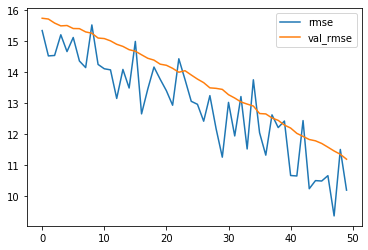

In [28]:
RMSE_COLS = ['rmse', 'val_rmse']

pd.DataFrame(history.history)[RMSE_COLS].plot()

# Making predictions with our model

To make predictions with our trained model, we can call the [predict method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), passing to it a dictionary of values. The `steps` parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set `steps=1` (setting `steps=None` would also work). Note, however, that if x is a `tf.data` dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [29]:
model.predict(
    x={
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)

array([[7.563088]], dtype=float32)

# Export and deploy our model

Of course, making individual predictions is not realistic, because we can't expect client code to have a model object in memory. For others to use our trained model, we'll have to export our model to a file, and expect client code to instantiate the model from that exported file. 

We'll export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [30]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)

tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

INFO:tensorflow:Assets written to: ./export/savedmodel\20220404184557\assets
INFO:tensorflow:Assets written to: ./export/savedmodel\20220404184557\assets


In [31]:
!saved_model_cli show \
    --tag_set serve \
    --signature_def serving_default \
    --dir {EXPORT_PATH}

!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_passenger_count:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_longitude:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['prediction'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2022-04-04 18:46:09.526859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-04 18:46:09.527487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
FIND: Parameter format not correct


In [32]:
mystop
#stop here - the rest wouldn't work outside of GCP

NameError: name 'mystop' is not defined

## Deploy our model to Vertex AI

Finally, we will deploy our trained model to Vertex AI and see how we can make online predicitons. 

In [ ]:
PROJECT = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"
MODEL_DISPLAYNAME = f"taxifare_keras_functional-{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

# from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest"
)

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

In [ ]:
%%bash
# Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "\nHere are your current buckets:"
    gsutil ls
fi

In [ ]:
!gsutil cp -R $EXPORT_PATH gs://$BUCKET/$MODEL_DISPLAYNAME

In [ ]:
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri=f"gs://{BUCKET}/{MODEL_DISPLAYNAME}",
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

In [ ]:
MACHINE_TYPE = "n1-standard-2"

endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type=None,
    accelerator_count=None,
)

<img src='assets/taxi_fare_keras_func_model.png' width='80%'>
<sup>(image:Your model in Vertex AI)</sup>

In [ ]:
instance = {
    "pickup_longitude": -73.982683,
    "pickup_latitude": 40.742104,
    "dropoff_longitude": -73.983766,
    "dropoff_latitude": 40.755174,
    "passenger_count": 3.0,
}

In [ ]:
endpoint.predict([instance])

# Cleanup

When deploying a model to an endpoint for online prediction, the minimum `min-replica-count` is 1, and it is charged per node hour. So let's delete the endpoint to reduce unnecessary charges. Before we can delete the endpoint, we first undeploy all attached models... 

In [ ]:
endpoint.undeploy_all()

In [ ]:
endpoint.delete()

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License